# Bitcoin analysis and forecast based on historical trade data

### Readme

This is a test for me to get started with FB Prophet. The prediction and forecast is just for testing and should not be taken seriously. Of course, if the prediction and forecast is correct, I'll take all the honor and glory and you should hire me as a great data analyst. However, the analysis shows some interesting stuff nonetheless.

The trade data is the timeframe from 2011-01-06 to 2018-03-03. The prediction and forecast is for one year. 

We should check back latest 2019-03-03 to see if the forecast was correct and to make a new one ;)

### Resources
#### Prophet
https://research.fb.com/prophet-forecasting-at-scale/
#### Bitcoin trade history CSV (I used the € data BTW)
http://api.bitcoincharts.com/v1/csv/

In [1]:
import warnings
import datetime
import pandas as pd
#import numpy as np
from fbprophet import Prophet

#warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

def dateparse (time_in_secs):    
    dt = datetime.datetime.fromtimestamp(float(time_in_secs))
    return dt.replace(hour=0, minute=0, second=0, microsecond=0)

df = pd.read_csv('bitcoin_trade_history.csv' ,parse_dates=['ds'], date_parser=dateparse, usecols=['ds', 'y'])
df.head()

,ds,y
0,2011-01-06,0.24990
1,2011-01-06,0.25499
2,2011-01-06,0.25499
3,2011-01-10,0.27100
4,2011-01-12,0.26000


Next we consolidate the dates and find the highest trade for the day

In [2]:
dates = [ ]
high_values = [ ]
dates.append(df['ds'][0])
high_values.append(df['y'][0])
for x in range(1, len(df['ds'])):
    if (df['ds'][x] > dates[len(dates)-1]):
        dates.append(df['ds'][x])
        high_values.append(df['y'][x])
    elif (df['y'][x] > high_values[len(dates)-1]):
        high_values[len(dates)-1] = df['y'][x]
               
dfc = pd.DataFrame({'ds': dates,'y': high_values})
dfc.head()

,ds,y
0,2011-01-06,0.25499
1,2011-01-10,0.27100
2,2011-01-12,0.26000
3,2011-01-13,0.28519
4,2011-01-14,0.29900


We take the consolidated data and take only the last year

In [3]:
dates_365 = [ ]
values_365 = [ ]
for x in range(0, len(dfc['ds'])):
    if (dfc['ds'][x] > pd.Timestamp('2017-03-03')):
        dates_365.append(dfc['ds'][x])
        values_365.append(dfc['y'][x])
dfc_365 = pd.DataFrame({'ds': dates_365,'y': values_365})
dfc_365.head()

,ds,y
0,2017-03-04,1229.58
1,2017-03-05,1209.99
2,2017-03-06,1229.94
3,2017-03-07,1220.00
4,2017-03-08,1210.00


In [4]:
m = Prophet(daily_seasonality=False)
m.fit(dfc)

In [5]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
2612,2019-02-25
2613,2019-02-26
2614,2019-02-27
2615,2019-02-28
2616,2019-03-01


In [6]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2612,2019-02-25,15717.096865,14326.352386,17102.067236
2613,2019-02-26,15736.982273,14362.045698,17247.512353
2614,2019-02-27,15763.978108,14454.291532,17243.641209
2615,2019-02-28,15781.768964,14241.364130,17188.050486
2616,2019-03-01,15827.051125,14407.872708,17225.613087


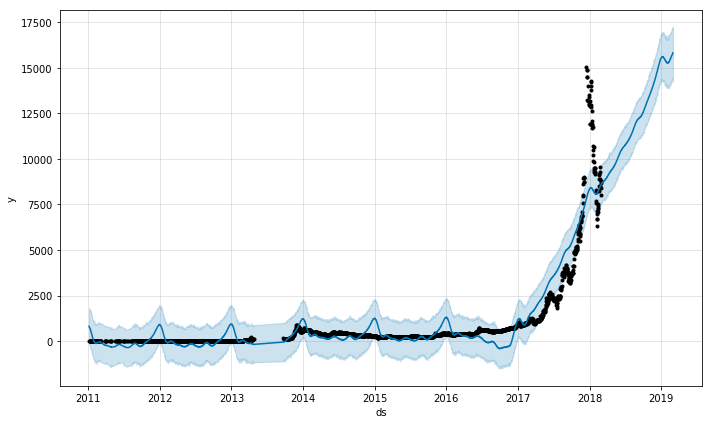

In [7]:
m.plot(forecast);

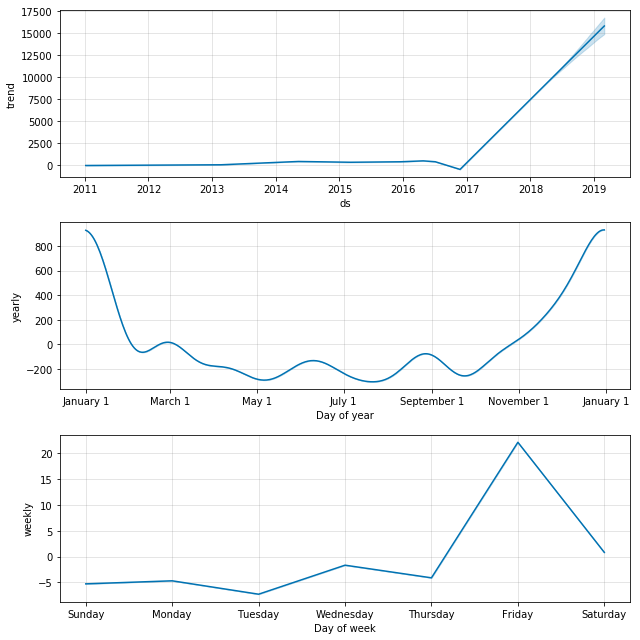

In [8]:
m.plot_components(forecast);

Now let's assume that the end of 2017 run was an outlier. We remove the outlier and see how the forecast changes

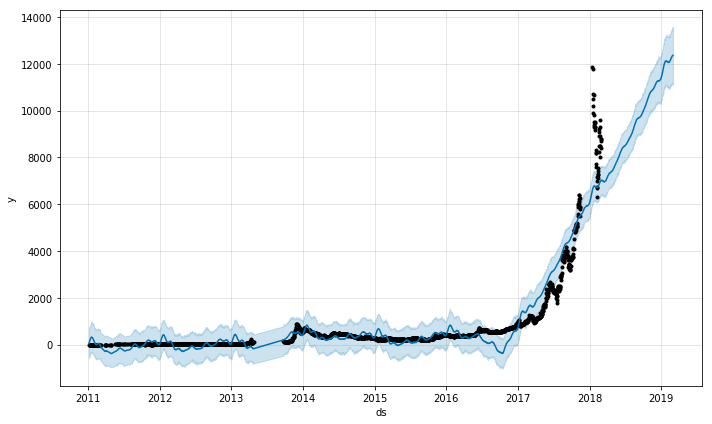

In [9]:
outlier_from = pd.Timestamp('2017-11-15')
outlier_to = pd.Timestamp('2018-01-15')
for x in range(0, len(dates)-1):
    if (dates[x] > outlier_from and dates[x] < outlier_to):
        high_values[x] = None
mwo = Prophet(daily_seasonality=False)
dfc_wo = pd.DataFrame({'ds': dates,'y': high_values})
mwo.fit(dfc_wo)
future_wo = mwo.make_future_dataframe(periods=365)
forecast_without_outliers = mwo.predict(future_wo)
mwo.plot(forecast_without_outliers);

And because it's easy we plot again based on the cleaned up data to see the differences

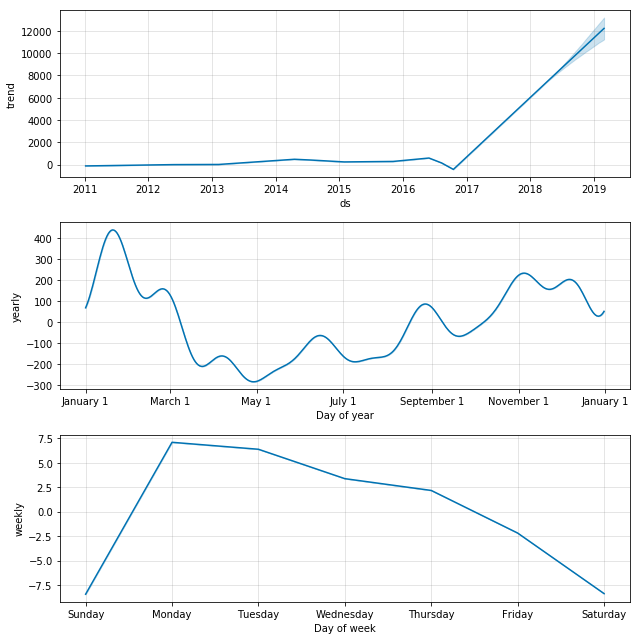

In [10]:
mwo.plot_components(forecast_without_outliers);

And another forecast where we just run with the cleaned data from the past year

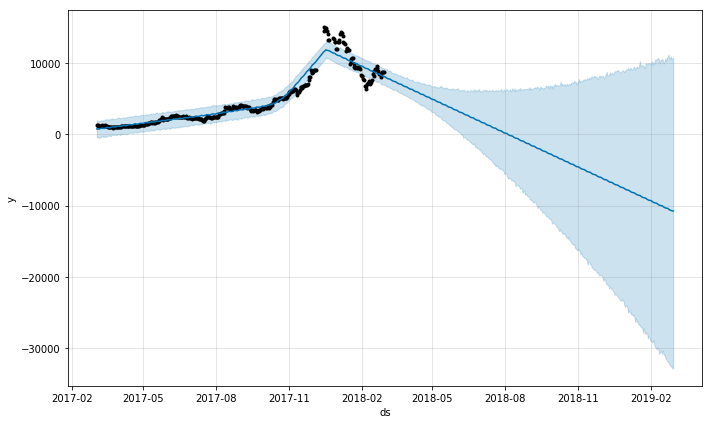

In [11]:
m_365 = Prophet(daily_seasonality=False, yearly_seasonality=False)
m_365.fit(dfc_365)
future_365 = m_365.make_future_dataframe(periods=365)
forecast_365 = m_365.predict(future_365)
m_365.plot(forecast_365);